In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

if torch.cuda.is_available():
    device = torch.device('cuda:0')
print(device)

cuda:0


## MNIST in Pytorch

[Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=True, num_workers=2)

0it [00:00, ?it/s]

9920512it [00:06, 1593082.78it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 73188.05it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 946640.80it/s]                              
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 26027.60it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


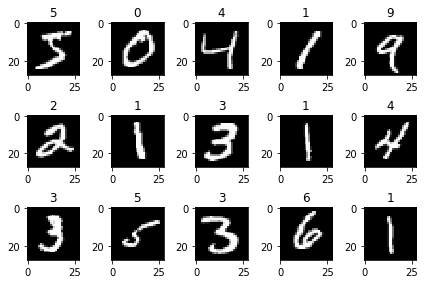

In [4]:
for i in range(15):
    img, title = mnist_trainset.data[i], mnist_trainset.targets[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title.item())
    plt.imshow(img.numpy(), cmap="gray")
plt.tight_layout()
plt.show()

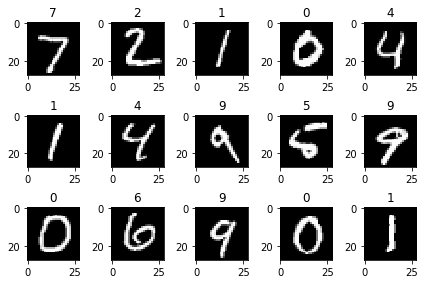

In [5]:
for i in range(15):
    img, title = mnist_testset.data[i], mnist_testset.targets[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title.item())
    plt.imshow(img.numpy(), cmap="gray")
plt.tight_layout()
plt.show()

In [6]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(400, 128)  # 32 x 32 from image dimension
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = NeuralNetwork()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 0 and i > 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  1001] loss: 1.047
[2,  1001] loss: 0.156
[3,  1001] loss: 0.085
[4,  1001] loss: 0.060
[5,  1001] loss: 0.047
[6,  1001] loss: 0.039
[7,  1001] loss: 0.034
[8,  1001] loss: 0.031
[9,  1001] loss: 0.028
[10,  1001] loss: 0.025
[11,  1001] loss: 0.023
[12,  1001] loss: 0.021
[13,  1001] loss: 0.020
[14,  1001] loss: 0.018
[15,  1001] loss: 0.017
Finished Training


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = model(images.to(device))
classes = range(0, 10)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:      8     6     1     0


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in classes:
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 97 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 96 %
Accuracy of     6 : 96 %
Accuracy of     7 : 97 %
Accuracy of     8 : 99 %
Accuracy of     9 : 94 %


## CIFAR in Pytorch


In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170352640/170498071 [01:28<00:00, 1958177.53it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


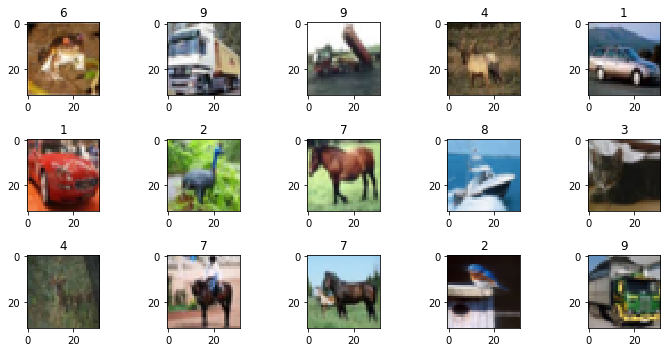

In [12]:
plt.figure(figsize=(10, 5))
for i in range(15):
    img, title = cifar_trainset.data[i], cifar_trainset.targets[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title)
    plt.imshow(img)
plt.tight_layout()
plt.show()

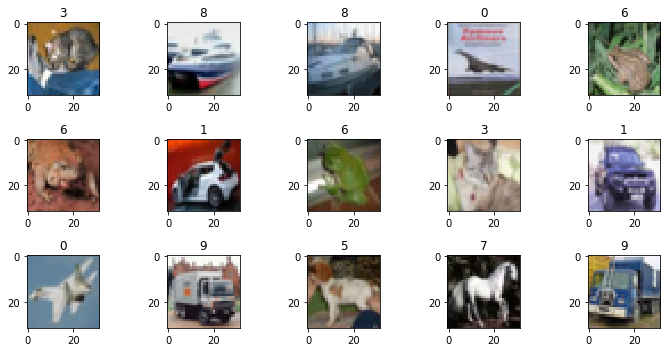

In [13]:
plt.figure(figsize=(10, 5))
for i in range(15):
    img, title = cifar_testset.data[i], cifar_testset.targets[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title)
    plt.imshow(img)
plt.tight_layout()
plt.show()

In [14]:
class CifarNeuralNetwork(nn.Module):

    def __init__(self):
        super(CifarNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 128)  # 32 x 32 from image dimension
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = CifarNeuralNetwork()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(model)

CifarNeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [15]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 0 and i > 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  1001] loss: 1.123


170500096it [01:40, 1958177.53it/s]                               

[2,  1001] loss: 0.879
[3,  1001] loss: 0.762
[4,  1001] loss: 0.695
[5,  1001] loss: 0.644
[6,  1001] loss: 0.600
[7,  1001] loss: 0.557
[8,  1001] loss: 0.528
[9,  1001] loss: 0.507
[10,  1001] loss: 0.482
[11,  1001] loss: 0.462
[12,  1001] loss: 0.448
[13,  1001] loss: 0.427
[14,  1001] loss: 0.414
[15,  1001] loss: 0.400
Finished Training


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i, cls in enumerate(classes):
    print('Accuracy of %5s : %2d %%' % (cls, 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 88 %
Accuracy of  bird : 44 %
Accuracy of   cat : 58 %
Accuracy of  deer : 52 %
Accuracy of   dog : 46 %
Accuracy of  frog : 85 %
Accuracy of horse : 63 %
Accuracy of  ship : 88 %
Accuracy of truck : 72 %
